In [32]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.utils import VotingSchemas
from src.outcomes import plurality_outcome,borda_outcome,veto_outcome, for_two_outcome
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
import os
import numpy as np
import matplotlib.pyplot as plt

In [33]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

In [34]:
voting = utils.read_voting(path_voting, table_name="five_candidates")
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5,voter_6,voter_7,voter_8,voter_9,...,voter_40,voter_41,voter_42,voter_43,voter_44,voter_45,voter_46,voter_47,voter_48,voter_49
preference_0,2,0,1,4,2,2,0,1,4,3,...,1,4,4,0,2,2,1,1,1,1
preference_1,3,1,2,1,0,4,1,3,2,2,...,0,0,1,4,1,1,3,0,4,3
preference_2,4,4,3,2,4,3,2,4,3,1,...,3,3,3,2,0,3,2,2,0,2
preference_3,0,2,4,0,1,1,3,2,1,4,...,4,2,2,3,4,4,0,3,3,0
preference_4,1,3,0,3,3,0,4,0,0,0,...,2,1,0,1,3,0,4,4,2,4


In [35]:
outcomes = all_schemas_outcomes(voting)
outcomes_df = all_schemas_outcomes_to_pandas(outcomes)
outcomes_df

,0,1,2,3,4,Winner
Plurality Voting,10,12,10,5,13,4
Voting for Two,18,24,20,17,21,1
Veto Voting,36,42,39,38,45,4
Borda Voting,91,114,99,87,109,1


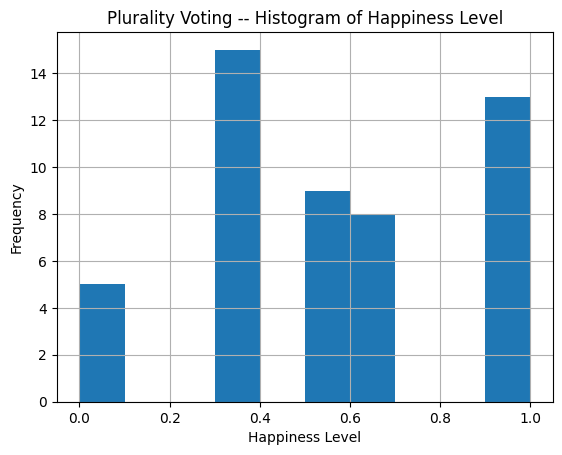

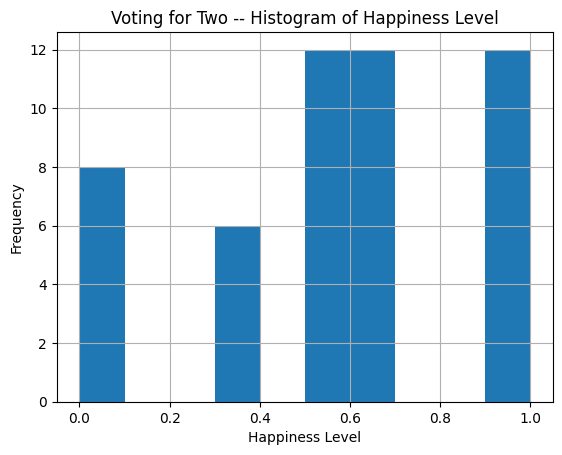

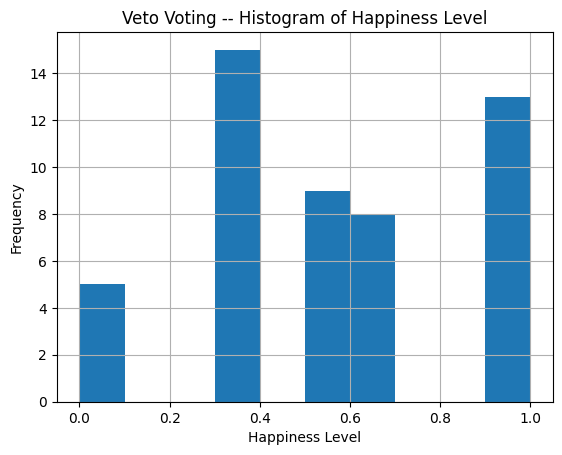

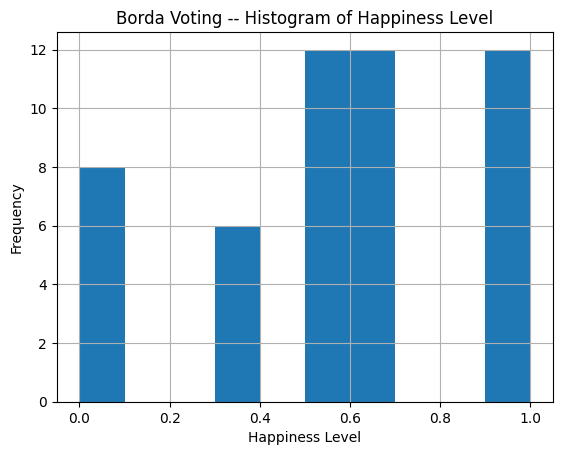

In [36]:

for scheme in VotingSchemas:
    pv_h = HappinessLevel(voting, outcomes[scheme.value].winner, scheme).run().histogram()


In [44]:
for scheme in [plurality_outcome, for_two_outcome, veto_outcome, borda_outcome]:
    pv_s = StrategicVoting(voting, pv_h, scheme).run()

AttributeError: 'NoneType' object has no attribute 'voting_schema'